# 27 条件变量sync.Cond （上）
上一节中我们主要讨论的是互斥锁，今天我们讨论以下条件变量conditional variable

## 前导内容：条件变量与互斥锁
我们常常会把条件变量这个同步工具拿来与互斥锁一起讨论。实际上，条件变量是基于互斥锁的，它必须有互斥锁的支撑才能发挥作用。

条件变量**并不是被用来保护临界区和共享资源的，它是用于协调想要访问共享资源的那些线程的。**当共享资源的状态发生变化时，它可以被用来通知被互斥锁阻塞的线程。

比如说，我们两个人在共同执行一项秘密任务，这需要在不直接联系和见面的前提下进行。我需要向一个信箱里放置情报，你需要从这个信箱中获取情报。这个信箱就相当于一个共享资源，而我们就分别是进行写操作的线程和进行读操作的线程。

如果我在放置的时候发现信箱里还有未被取走的情报，那就不再放置，而先返回。另一方面，如果你在获取的时候发现信箱里没有情报，那也只能先回去了。这就相当于写的线程或读的线程阻塞的情况。

虽然我们俩都有信箱的钥匙，但是同一时刻只能有一个人插入钥匙并打开信箱，这就是锁的作用了。更何况咱们俩是不能直接见面的，所以这个信箱本身就可以被视为一个临界区。

尽管没有协调好，咱们俩仍然要想方设法的完成任务啊。所以，如果信箱里有情报，而你却迟迟未取走，那我就需要每过一段时间带着新情报去检查一次，若发现信箱空了，我就需要及时地把新情报放到里面。

另一方面，如果信箱里一直没有情报，那你也要每过一段时间去打开看看，一旦有了情报就及时地取走。这么做是可以的，但就是太危险了，很容易被敌人发现。

后来，我们又想了一个计策，各自雇佣了一个不起眼的小孩儿。如果早上七点有一个戴红色帽子的小孩儿从你家楼下路过，那么就意味着信箱里有了新情报。另一边，如果上午九点有一个戴蓝色帽子的小孩儿从我家楼下路过，那就说明你已经从信箱中取走了情报。

这样一来，咱们执行任务的隐蔽性高多了，并且效率的提升非常显著。**这两个戴不同颜色帽子的小孩儿就相当于条件变量，在共享资源的状态产生变化的时候，起到了通知的作用**。

当然了，我们是在用Go语言编写程序，而不是在执行什么秘密任务。因此，条件变量在这里的最大优势就是在效率方面的提升。当共享资源的状态不满足条件的时候，想操作它的线程再也不用循环往复地做检查了，只要等待通知就好了。

说到这里，想考考你知道怎么使用条件变量吗？所以，我们
**今天的问题就是：条件变量怎样与互斥锁配合使用？**

这道题的典型回答是：条件变量的初始化离不开互斥锁，并且它的方法有的也是基于互斥锁的。

条件变量提供的方法有三个：等待通知（wait）、单发通知（signal）和广播通知（broadcast）。

我们在利用条件变量等待通知的时候，需要在**它基于的那个互斥锁保护**下进行。而在进行**单发通知或广播通知**的时候，却是恰恰相反的，也就是说，需要在对应的**互斥锁解锁**之后再做这两种操作。

## 问题解析
这个问题看起来很简单，但其实可以基于它,延伸出很多其他的问题。比如，每个方法的使用时机是什么？又比如，每个方法执行的内部流程是怎样的？

下面，我们一边用代码实现前面那个例子，一边讨论条件变量的使用。

首先，我们先来创建如下几个变量。

In [ ]:
var mailbox uint8
var lock sync.RWMutex
sendcond := sync.NewCond(&lock)
recvcond := sync.NewCond(lock.Rlocker())

变量`mailbox`代表信箱，是`uint8`类型的。 若它的值为`0`则表示信箱中没有情报，而当它的值为`1`时则说明信箱中有情报。lock是一个类型为sync.RWMutex的变量，是一个读写锁，也可以被视为信箱上的那把锁。

另外，基于这把锁，我还创建了两个代表条件变量的变量，名字分别叫`sendCond`和`recvCond`。 它们都是`*sync.Cond`类型的，同时也都是由`sync.NewCond`函数来初始化的。

与`sync.Mutex`类型和`sync.RWMutex`类型不同，`sync.Cond`类型并不是开箱即用的。我们只能利用`sync.NewCond`函数创建它的**指针值**。这个函数需要一个`sync.Locker`类型的参数值。

还记得吗？我在前面说过，条件变量是基于**互斥锁的，它必须有互斥锁的支撑才能够起作用**。因此，这里的参数值是不可或缺的，它会参与到条件变量的方法实现当中。

sync.Locker其实是一个接口，在它的声明中只包含了两个方法定义，即：Lock()和Unlock()。sync.Mutex类型和sync.RWMutex类型都拥有Lock方法和Unlock方法，只不过它们都是指针方法。因此，这两个类型的**指针类型才是sync.Locker接口的实现类型。**

我在为sendCond变量做初始化的时候，把基于lock变量的指针值传给了sync.NewCond函数。

原因是，lock变量的Lock方法和Unlock方法分别用于对其中写锁的锁定和解锁，它们与sendCond变量的含义是对应的。sendCond是专门为放置情报而准备的条件变量，向信箱里放置情报，可以被视为对共享资源的**写操作**。

相应的，recvCond变量代表的是专门为获取情报而准备的条件变量。 虽然获取情报也会涉及对信箱状态的改变，但是好在做这件事的人只会有你一个，而且我们也需要借此了解一下，条件变量与读写锁中的读锁的联用方式。所以，在这里，我们暂且把获取情报看做是对共享资源的**读操作**。

因此，为了初始化recvCond这个条件变量，我们需要的是lock变量中的读锁，并且还需要是sync.Locker类型的。

可是，lock变量中用于对读锁进行锁定和解锁的方法却是RLock和RUnlock，它们与sync.Locker接口中定义的方法并不匹配。

好在sync.RWMutex类型的RLocker方法可以实现这一需求。我们只要在调用sync.NewCond函数时，传入调用表达式lock.RLocker()的结果值，就可以使该函数返回符合要求的条件变量了。

为什么说通过lock.RLocker()得来的值就是**lock变量中的读锁**呢？实际上，这个值所拥有的Lock方法和Unlock方法，在其内部会分别调用lock变量的RLock方法和RUnlock方法。也就是说，前两个方法仅仅是后两个方法的代理而已。

**解释**：这个 RLocker() 返回的对象（前台）只是一个包装（或称为“适配器”）。它存在的唯一目的，就是把 RLock/RUnlock 这两个方法，伪装成标准 sync.Locker 接口所要求的 Lock/Unlock 方法。
当你调用“前台”的 Lock() 时，你实际上调用的是“真实老板”的 RLock()。RLocker 就是这座“桥梁”。

好了，我们现在有四个变量。一个是代表信箱的mailbox，一个是代表信箱上的锁的lock。还有两个是，代表了蓝帽子小孩儿的sendCond，以及代表了红帽子小孩儿的recvCond。
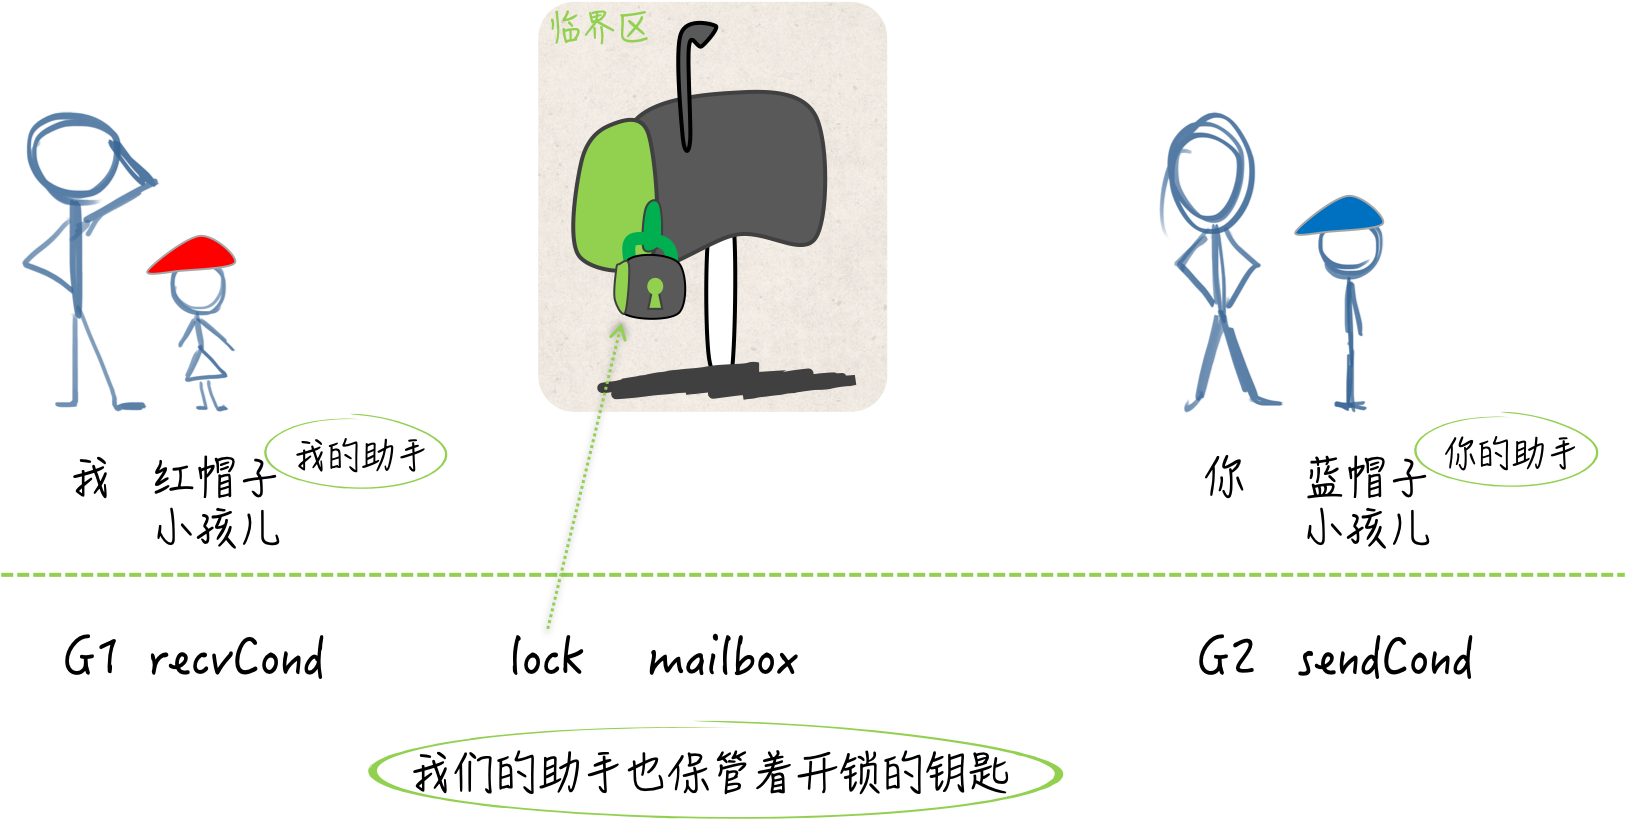

我，现在是一个goroutine（携带的go函数），想要适时地向信箱里放置情报并通知你，应该怎么做呢？

In [ ]:
lock.Lock()
for mailbox == 1 {
 sendCond.Wait()
}
mailbox = 1
lock.Unlock()
recvCond.Signal()

我肯定需要先调用`lock`变量的`Lock`方法。注意，**这个Lock方法在这里意味的是：持有信箱上的锁，并且有打开信箱的权利，而不是锁上这个锁。**

然后，我要检查`mailbox`变量的值是否等于1，也就是说，要看看信箱里是不是还存有情报。如果还有情报，那么我就回家去等蓝帽子小孩儿了。

这就是那条`for`语句以及其中的调用表达式`sendCond.Wait()`所表示的含义了。你可能会问，为什么这里是`for`语句而不是`if`语句呢？我在后面会对此进行解释的。

我们再往后看，如果信箱里没有情报，那么我就把新情报放进去，关上信箱、锁上锁，然后离开。用代码表达出来就是`mailbox = 1`和`lock.Unlock()`。

离开之后我还要做一件事，那就是让红帽子小孩儿准时去你家楼下路过。也就是说，我会及时地通知你“信箱里已经有新情报了”，我们调用recvCond的Signal方法就可以实现这一步骤。

另一方面，你现在是另一个goroutine，想要适时地从信箱中获取情报，然后通知我。

In [ ]:
lock.RLock()
for mailbox == 0 {
 recvCond.Wait()
}
mailbox = 0
lock.RUnlock()
sendCond.Signal()

你跟我做的事情在流程上其实基本一致，只不过每一步操作的对象是不同的。你需要调用的是`lock`变量的`RLock`方法。因为你要进行的是读操作，并且会使用`recvCond`变量作为辅助。`recvCond`与`lock`变量的读锁是对应的。

在打开信箱后，你要关注的是信箱里是不是没有情报，也就是检查mailbox变量的值是否等于0。如果它确实等于0，那么你就需要回家去等红帽子小孩儿，也就是调用`recvCond`的`Wait`方法。这里使用的依然是`for`语句。

如果信箱里有情报，那么你就应该取走情报，关上信箱、锁上锁，然后离开。对应的代码是`mailbox = 0`和`lock.RUnlock()`。之后，你还需要让蓝帽子小孩儿准时去我家楼下路过。这样我就知道信箱中的情报已经被你获取了。

以上这些，就是对咱们俩要执行秘密任务的代码实现。其中的条件变量的用法需要你特别注意。

再强调一下，只要条件不满足，我就会通过调用`sendCond`变量的Wait方法，去等待你的通知，只有在收到通知之后我才会再次检查信箱。

另外，当我需要通知你的时候，我会调用`recvCond`变量的Signal方法。你使用这两个条件变量的方式正好与我相反。你可能也看出来了，利用条件变量可以实现单向的通知，而双向的通知则需要两个条件变量。这也是条件变量的基本使用规则。

你可以打开demo61.go文件，看到上述例子的全部实现代码。

## 总结

我们这两期的文章会围绕条件变量的内容展开，条件变量是基于互斥锁的一种同步工具，它必须有互斥锁的支撑才能发挥作用。 条件变量可以协调那些想要访问共享资源的线程。当共享资源的状态发生变化时，它可以被用来通知被互斥锁阻塞的线程。我在文章举了一个两人访问信箱的例子，并用代码实现了这个过程。
## 思考题
*sync.Cond类型的值可以被传递吗？那sync.Cond类型的值呢？
sync.Cond 类型的值不能直接传递，必须通过指针 *sync.Cond 来传递和使用，以确保所有协程操作的是同一个条件变量实例。